# Danbury AI June 2018 Competition


** About the Data **

We are using the MNIST data obtained from the [digit recognizer competition on Kaggle](https://www.kaggle.com/c/digit-recognizer/data). MNIST was produced by [Yann Lecun et al.](http://yann.lecun.com/exdb/mnist/) and their page has a great list of benchmark results. The street view house numbers (SVHN) was obtained from [stanfords website](http://ufldl.stanford.edu/housenumbers/). 

In [42]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact
from keras.layers import Input, Dense, Dropout,Conv2D,MaxPooling2D,Flatten,GlobalMaxPooling2D
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Extract, Transform, Load (ETL)

In [5]:
mnist = pd.read_csv("MNIST_train_28x28.csv")
mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
mnist_x = mnist.values[:,1:].reshape(mnist.shape[0],28,28,1)
mnist_y = mnist.values[:,0]


mnist_train_x, mnist_validation_x, mnist_train_y, mnist_validation_y = train_test_split(mnist_x,mnist_y,test_size=0.2)

In [26]:
def dispMNIST(imSel = 0):
    plt.title("Digit class: {0}".format(mnist_y[imSel]))
    plt.imshow(mnist_x[imSel].reshape(28,28))
    plt.show()

interact(dispMNIST,imSel=(0,100))

interactive(children=(IntSlider(value=0, description='imSel'), Output()), _dom_classes=('widget-interact',))

<function __main__.dispMNIST>

In [73]:
imSel = 0
svhn = sio.loadmat("SVHN_train_32x32.mat")
svhn_x = svhn["X"]
svhn_x = np.moveaxis(svhn_x,-1,0)
svhn_y = svhn["y"]
svhn_y = (svhn_y-1).reshape(svhn_y.shape[0])

svhn_train_x, svhn_validation_x, svhn_train_y, svhn_validation_y = train_test_split(svhn_x,svhn_y,test_size=0.2)

In [11]:
def dispSVHN(imSel = 0):
    plt.title("Digit class: {0}".format(svhn_y[imSel]+1))
    plt.imshow(svhn_x[imSel,:,:,:])
    plt.show()
    
interact(dispSVHN,imSel=(0,100))

interactive(children=(IntSlider(value=0, description='imSel'), Output()), _dom_classes=('widget-interact',))

<function __main__.dispSVHN>

## Modeling

In [65]:
def makeModel(inputSize):
    inputs = Input(shape=inputSize,name="input")
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(100,activation='relu')(x)
    out = Dense(10,activation='softmax', name="output")(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc'])
    
    return model

def learningCurves(hist):
    histLoss_train      = hist.history['loss']
    histLoss_validation = hist.history['val_loss']
    minValLoss = np.min(histLoss_validation)
    maxValAcc  = np.max(hist.history["val_acc"])
    epochs = len(histLoss_train)
    
    plt.figure(figsize=(12,12))
    
    plt.plot(range(epochs),histLoss_train, label="Training Loss", color="#acc6ef")

    plt.plot(range(epochs),histLoss_validation, label="Validation Loss", color="#a7e295")

    plt.scatter(np.argmin(histLoss_validation),minValLoss,zorder=10,color="green")

    plt.xlabel('Epochs',fontsize=14)
    plt.title("Learning Curves",fontsize=20)

    plt.legend()
    plt.show()

    print("Max validation accuracy: {0}".format(maxValAcc))
    print("Minimum validation loss: {0}".format(minValLoss))
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
global_max_pooling2d_12 (Glo (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               3300      
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total para

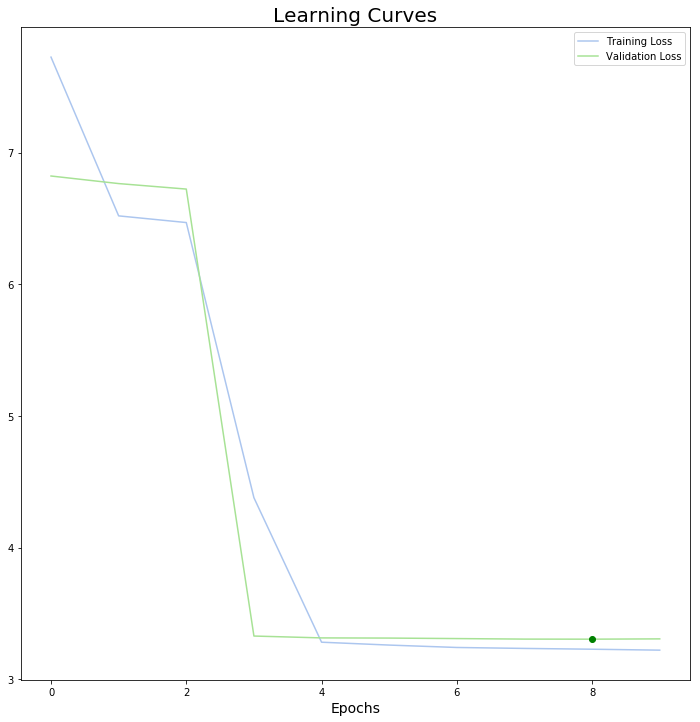

Max validation accuracy: 0.7745238067138762
Minimum validation loss: 3.304325970865431


In [70]:
model = makeModel((28,28,1,))
model.summary()
hist1 = model.fit(mnist_train_x.reshape(mnist_train_x.shape[0],28,28,1), to_categorical(mnist_train_y,10),
                  batch_size=100,epochs=10,
                  validation_data=(mnist_validation_x,to_categorical(mnist_validation_y,10)))
learningCurves(hist1)

In [74]:
model2 = makeModel((32,32,3,))
model2.summary()
hist2 = model2.fit(svhn_train_x, to_categorical(svhn_train_y,10),batch_size=100,epochs=100,
                   validation_data=(svhn_validation_x,to_categorical(svhn_validation_y,10)))
learningCurves(hist2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
global_max_pooling2d_14 (Glo (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3300      
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total para

KeyboardInterrupt: 

In [121]:
res = model.predict(mnistTrain_x[0].reshape(1,28,28,1))
np.argmax(res)

1